In [2]:
import psycopg2
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

#### Connecting to database 

In [3]:
conn = psycopg2.connect(
    host = '165.22.22.202' ,
    database = 'gsmarena' ,
    user = 'anomaly' ,
    password = 'Hitman.agent47'    
)

### SIZE ~ PPI_DENSITY

#### Fetching required tables from database 

In [4]:
cur = conn.cursor()
cur.execute(''' SELECT "DisplaySize" , "PPIDensity"
                FROM devices;''')

rows = cur.fetchall()
col_names = [desc[0] for desc in cur.description]

display_ppi = pd.DataFrame(rows, columns=col_names)

In [5]:
display_ppi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4659 entries, 0 to 4658
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DisplaySize  4659 non-null   float64
 1   PPIDensity   4659 non-null   object 
dtypes: float64(1), object(1)
memory usage: 72.9+ KB


#### Convert ppi into float type

In [6]:
display_ppi['PPIDensity'] = display_ppi['PPIDensity'].astype('float')

In [7]:
display_ppi

,DisplaySize,PPIDensity
0,6.55,402.0
1,6.67,395.0
2,6.67,395.0
3,6.67,395.0
4,6.28,419.0
...,...,...
4654,5.50,403.0
4655,5.00,445.0
4656,5.20,424.0
4657,5.50,401.0


#### Split data based on their display size 

In [8]:
small_display = display_ppi[display_ppi['DisplaySize'] < 7 ]['PPIDensity']
big_display = display_ppi[display_ppi['DisplaySize'] >= 7 ]['PPIDensity']

#### Does DisplaySize have normal distribution ?

/Applications/anaconda3/envs/quera/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='PPIDensity', ylabel='Count'>

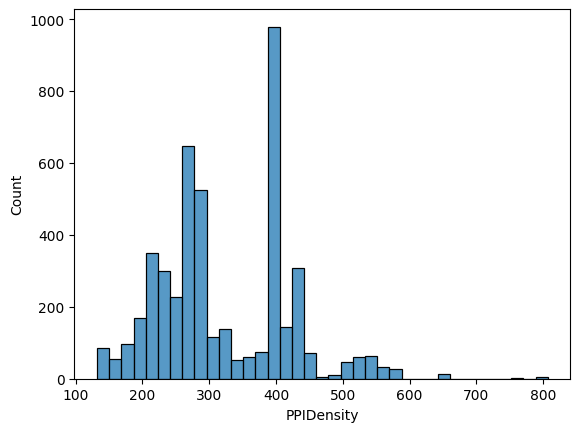

In [9]:
sns.histplot(display_ppi['PPIDensity'])

In [10]:
from scipy.stats import normaltest

In [11]:
stat_dagostino, p_value_dagostino = normaltest(display_ppi['PPIDensity'])
print(f"D'Agostino-Pearson Test of : Statistics={stat_dagostino}, p-value={p_value_dagostino}")

D'Agostino-Pearson Test of : Statistics=214.1230387002057, p-value=3.1898695438551026e-47


PPIDensity does not have normal distribution so we nedd to use mannwhitneyu test to understand whether the size of display effects PPIDensity 

#### U_Test

In [12]:
from scipy.stats import mannwhitneyu

In [13]:
u_statistic, p_value = mannwhitneyu(small_display, big_display )
p_value

4.84966238286479e-184

In [14]:
u_statistic, p_value = mannwhitneyu(small_display, big_display , alternative='greater')
p_value

2.424831191432395e-184

In [15]:
u_statistic, p_value = mannwhitneyu( big_display , small_display, alternative='greater')
p_value

1.0

#### Make ppidensity normal 

In [16]:
from scipy.stats import yeojohnson , boxcox 

In [19]:
display_ppi['Normal_PPIDensity'] = yeojohnson(display_ppi['PPIDensity'])[0]

In [20]:
stat_dagostino, p_value_dagostino = normaltest(display_ppi['Normal_PPIDensity'])
print(f"D'Agostino-Pearson Test of : Statistics={stat_dagostino}, p-value={p_value_dagostino}")

D'Agostino-Pearson Test of : Statistics=106.4079213639773, p-value=7.830932137628405e-24


In [21]:
display_ppi['Normal_PPIDensity'] = boxcox(display_ppi['PPIDensity'])[0]

In [22]:
stat_dagostino, p_value_dagostino = normaltest(display_ppi['Normal_PPIDensity'])
print(f"D'Agostino-Pearson Test of : Statistics={stat_dagostino}, p-value={p_value_dagostino}")

D'Agostino-Pearson Test of : Statistics=106.07364232124097, p-value=9.255528708930373e-24
